In [116]:
# IMPORTING LIBRARIES 

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

from sklearn.model_selection import KFold 
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.metrics import roc_curve,auc
from sklearn.ensemble import AdaBoostClassifier
from matplotlib_venn import venn2

from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
pd.options.mode.chained_assignment = None  



In [117]:
# Loading data

microbiology = pd.read_csv("/Users/sirisadashiva/Desktop/Machine_Learning/mimic3/MICROBIOLOGYEVENTS.csv")
microbiology.drop(['ROW_ID'], axis=1, inplace=True)

##############################################################################################################

drgcodes = pd.read_csv("/Users/sirisadashiva/Desktop/Machine_Learning/mimic3/DRGCODES.csv")
drgcodes.drop(['ROW_ID'], axis=1, inplace=True)

drgcodes['DESCRIPTION'].unique()

##############################################################################################################

chartevents=pd.read_csv("/Users/sirisadashiva/Desktop/Machine_Learning/mimic3/chartevents_split2.csv")
chartevents.drop(['ROW_ID'], axis=1, inplace=True)

##############################################################################################################

icu_stays=pd.read_csv("/Users/sirisadashiva/Desktop/Machine_Learning/mimic3/ICUSTAYS.csv")
icu_stays.drop(['ROW_ID'], axis=1, inplace=True)

##############################################################################################################
positive_culture=microbiology

positive_culture.dropna(subset =['ORG_ITEMID'],inplace=True)

##############################################################################################################

patients = pd.read_csv('/Users/sirisadashiva/Desktop/Machine_Learning/mimic3/PATIENTS.csv')
patients.drop(['ROW_ID'], axis=1, inplace=True)

##############################################################################################################

admissions= pd.read_csv('/Users/sirisadashiva/Desktop/Machine_Learning/mimic3/ADMISSIONS.csv')
admissions.drop(['ROW_ID'], axis=1, inplace=True)

##############################################################################################################

d_items = pd.read_csv('/Users/sirisadashiva/Desktop/Machine_Learning/mimic3/d_items.csv')
d_items.drop(['ROW_ID'], axis=1, inplace=True)

#######################################POSITIVE CULTURE #######################################################################

#Obtaining patients who tested positive 

positive_culture.drop(positive_culture[~positive_culture['SPEC_TYPE_DESC'].isin(['SUPRAPUBIC ASPIRATE','TISSUE','TRACHEAL ASPIRATE','FLUID WOUND','BLOOD CULTURE - NEONATE',
                 'FLUID RECEIVED IN BLOOD CULTURE BOTTLES','BLOOD CULTURE','BLOOD CULTURE ( MYCO/F LYTIC BOTTLE)',
'ASPIRATE','ABSCESS','TRANSTRACHEAL ASPIRATE','SPUTUM','CSF;SPINAL FLUID'])].index,inplace=True)



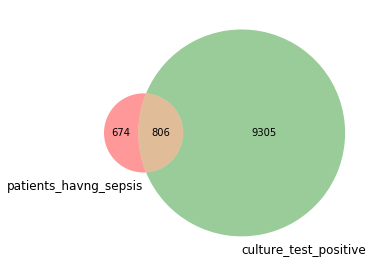

In [96]:
# TO FIND THE OVERLAP BETWEEN DRGCODES(Patients having sepsis) AND PATIENTS WHO TESTED POSITIVE

drgcodes['SEPSIS'] = (drgcodes['DESCRIPTION'].str.contains('sepsis',case = 0))
drgcodes['SEPSIS'] = drgcodes['SEPSIS'].map({False: 0, True: 1})

drgcodes['sepsis'] = drgcodes['SEPSIS'].apply(lambda x: x if x == 0 or x == 1 else -1)
drgcodes.drop(drgcodes[drgcodes['sepsis'] == -1].index, inplace=True)

#Patients having sepsis
temp = drgcodes
temp.drop(temp[~temp['sepsis'].isin([1])].index,inplace=True)
#Total patients having sepsis

plt.figure(figsize=(5,5))
set1 = set(temp['SUBJECT_ID'])
set2 = set(positive_culture['SUBJECT_ID'])

venn2([set1, set2], ('patients_havng_sepsis', 'culture_test_positive'))
plt.show()



In [118]:
#############################################PATIENT & ADMISSION##############################################################

drgcodes = pd.read_csv("/Users/sirisadashiva/Desktop/Machine_Learning/mimic3/DRGCODES.csv")
drgcodes.drop(['ROW_ID'], axis=1, inplace=True)

admissions['minadmit']=admissions.groupby('SUBJECT_ID')['ADMITTIME'].transform('min')


# I merging patients and admissions

patient_admission =pd.merge(patients, admissions,how = 'inner',on = ['SUBJECT_ID'])

#converting mindadmit time and DOB into datetime format
patient_admission['minadmit'] = pd.to_datetime(patient_admission['minadmit'], infer_datetime_format=True)
patient_admission['DOB'] = pd.to_datetime(patient_admission['DOB'], infer_datetime_format=True)


# calculating total age through minadmit and date of birth
patient_admission['age'] = list(map(lambda x: x.days , (patient_admission['minadmit'] - patient_admission['DOB'])/365.242 ))

#converting ages < 0 (i.e -285) into 300
patient_admission['age'] = patient_admission['age'].apply(lambda x: 300 if x< 0 else x )


#grouping ages 0: neonate 1:children 2:adult
patient_admission['age_group'] = patient_admission['age'].apply(lambda x: 0 if x<=1 else 
                                                         1 if x>1 and x<18 else 
                                                         2 if x>18 and x<=89 else 
                                                         3 ) 


patient_admission.drop(['DISCHTIME','ADMITTIME','HAS_CHARTEVENTS_DATA','DIAGNOSIS','EDOUTTIME','EDREGTIME','RELIGION','LANGUAGE','DISCHARGE_LOCATION','ADMISSION_LOCATION','ADMISSION_TYPE','minadmit','DEATHTIME','DOB','DOD','DOD_HOSP','DOD_SSN'], axis=1, inplace=True)

patient_admission['sex'] = patient_admission['GENDER'].map({'F': 1, 'M': 0})

patient_admission.drop(['GENDER'], axis=1, inplace=True)



encode_category = LabelEncoder()
patient_admission['marital_encode'] = encode_category.fit_transform(patient_admission['MARITAL_STATUS'].astype(str))

patient_admission['ethnicity_encode'] = encode_category.fit_transform(patient_admission['ETHNICITY'].astype(str))


patient_admission['insurance_encode'] = encode_category.fit_transform(patient_admission['INSURANCE'].astype(str))


patient_admission.drop(['ETHNICITY','MARITAL_STATUS'], axis=1, inplace=True)


#################################################ICUSTAY and CHARTEVENTS############################################################



icu_stays.drop(icu_stays[icu_stays['LOS'] >= 110].index, inplace=True)

#round LOS
icu_stays.LOS = icu_stays.LOS.round()

#converting los of patients into 0 and 1 : 0 if <5 1 if >=5
icu_stays['binary_los'] = icu_stays['LOS'].apply(lambda x: 1 if x >=5 else 0)

icu_stays.drop(['OUTTIME','INTIME','FIRST_CAREUNIT','LAST_CAREUNIT','FIRST_WARDID','LAST_WARDID'], axis=1, inplace=True)


#combining d_items and chartevents
chart_icu= pd.merge(chartevents,d_items,how = 'inner',on = ['ITEMID'])

#combining d_chart with icu_stays
chart_icu = pd.merge(chart_icu, icu_stays,how = 'inner',on = ['SUBJECT_ID','HADM_ID','ICUSTAY_ID'])



#dropping unncessary columns
chart_icu.drop(['ERROR','WARNING','ABBREVIATION','RESULTSTATUS','STOPPED','LINKSTO','PARAM_TYPE','CONCEPTID','STORETIME'], axis=1, inplace=True)


#encoding fields

chart_icu['label_encode'] = encode_category.fit_transform(chart_icu['LABEL'].astype(str))


chart_icu['category_encode'] = encode_category.fit_transform(chart_icu['CATEGORY'].astype(str))



#calculating sofa scores
chart_icu['sofa_score']=0
chart_icu['sofa_sbp'] = 0
chart_icu['sofa_rr'] = 0
chart_icu['sofa_gcs'] = 0
chart_icu['heartrate'] = 0
chart_icu['fever'] = 0


#extracting systolic blood pressure
chart_icu['sofa_sbp'][(chart_icu['UNITNAME'] =='mmHg') & (chart_icu['VALUENUM'] <=100)] = 1

#extracting respiratory rate
chart_icu['sofa_rr'][(chart_icu['UNITNAME'] =='insp/min') & (chart_icu['VALUENUM'] >=22)] = 1

#extracting GCS
chart_icu['sofa_gcs'][(chart_icu['LABEL'] =='GcsApacheIIScore') & (chart_icu['VALUENUM'] <15)] = 1

#Adding up all the scores
chart_icu['sofa_score']=chart_icu['sofa_sbp']+chart_icu['sofa_rr']+chart_icu['sofa_gcs']



chart_icu['heartrate'][(chart_icu['VALUENUM'] > 90) & (chart_icu['VALUEOM'] == 'bpm')] = 1

chart_icu['fever'][((chart_icu['VALUENUM'] > 101) & (chart_icu['UNITNAME'] == '?F')) | (chart_icu['VALUENUM'] > 38.3) & (chart_icu['UNITNAME'] == '?C')] = 1


chart_icu.drop(['CHARTTIME','LABEL','CATEGORY','VALUEOM','UNITNAME','DBSOURCE_y'], axis=1, inplace=True)




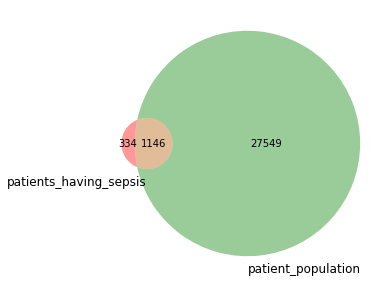

In [119]:
# TO FIND OVERLAP BETWEEN PATIENTS HAVING SEPSIS AND TOTAL PATIENT POPULATION

chart_icu = pd.merge(chart_icu, patient_admission,how = 'inner',on = ['SUBJECT_ID','HADM_ID'])

drgcodes['SEPSIS'] = (drgcodes['DESCRIPTION'].str.contains('sepsis',case = 0))
drgcodes['SEPSIS'] = drgcodes['SEPSIS'].map({False: 0, True: 1})

drgcodes['sepsis'] = drgcodes['SEPSIS'].apply(lambda x: x if x == 0 or x == 1 else -1)
drgcodes.drop(drgcodes[drgcodes['sepsis'] == -1].index, inplace=True)

#PATIENTS HAVING SEPSIS 
temp = drgcodes
temp.drop(temp[~temp['sepsis'].isin([1])].index,inplace=True)

# PLOTTING VENN DIAGRAM

plt.figure(figsize=(5,5))
set1 = set(temp['SUBJECT_ID'])
set2 = set(chart_icu['SUBJECT_ID'])

venn2([set1, set2], ('patients_having_sepsis', 'patient_population'))
plt.show()


In [99]:


##############################################################################################################

drgcodes = pd.read_csv("/Users/sirisadashiva/Desktop/Machine_Learning/mimic3/DRGCODES.csv")
drgcodes.drop(['ROW_ID'], axis=1, inplace=True)

#drgcodes['DESCRIPTION'].unique()

##############################################################################################################

chartevents=pd.read_csv("/Users/sirisadashiva/Desktop/Machine_Learning/mimic3/chartevents_split2.csv")
chartevents.drop(['ROW_ID'], axis=1, inplace=True)

##############################################################################################################

icu_stays=pd.read_csv("/Users/sirisadashiva/Desktop/Machine_Learning/mimic3/ICUSTAYS.csv")
icu_stays.drop(['ROW_ID'], axis=1, inplace=True)


##############################################################################################################

patients = pd.read_csv('/Users/sirisadashiva/Desktop/Machine_Learning/mimic3/PATIENTS.csv')
patients.drop(['ROW_ID'], axis=1, inplace=True)

##############################################################################################################

admissions= pd.read_csv('/Users/sirisadashiva/Desktop/Machine_Learning/mimic3/ADMISSIONS.csv')
admissions.drop(['ROW_ID'], axis=1, inplace=True)

##############################################################################################################

d_items = pd.read_csv('/Users/sirisadashiva/Desktop/Machine_Learning/mimic3/d_items.csv')
d_items.drop(['ROW_ID'], axis=1, inplace=True)


In [100]:
#############################################PATIENT & ADMISSION##############################################################


admissions['minadmit']=admissions.groupby('SUBJECT_ID')['ADMITTIME'].transform('min')


# I merging patients and admissions

patient_admission =pd.merge(patients, admissions,how = 'inner',on = ['SUBJECT_ID'])

#converting mindadmit time and DOB into datetime format
patient_admission['minadmit'] = pd.to_datetime(patient_admission['minadmit'], infer_datetime_format=True)
patient_admission['DOB'] = pd.to_datetime(patient_admission['DOB'], infer_datetime_format=True)


# calculating total age through minadmit and date of birth
patient_admission['age'] = list(map(lambda x: x.days , (patient_admission['minadmit'] - patient_admission['DOB'])/365.242 ))

#converting ages < 0 (i.e -285) into 300
patient_admission['age'] = patient_admission['age'].apply(lambda x: 300 if x< 0 else x )


#grouping ages 0: neonate 1:children 2:adult
patient_admission['age_group'] = patient_admission['age'].apply(lambda x: 0 if x<=1 else 
                                                         1 if x>1 and x<18 else 
                                                         2 if x>18 and x<=89 else 
                                                         3 ) 


patient_admission.drop(['DISCHTIME','ADMITTIME','HAS_CHARTEVENTS_DATA','DIAGNOSIS','EDOUTTIME','EDREGTIME','RELIGION','LANGUAGE','DISCHARGE_LOCATION','ADMISSION_LOCATION','ADMISSION_TYPE','minadmit','DEATHTIME','DOB','DOD','DOD_HOSP','DOD_SSN'], axis=1, inplace=True)

patient_admission['sex'] = patient_admission['GENDER'].map({'F': 1, 'M': 0})

patient_admission.drop(['GENDER'], axis=1, inplace=True)



encode_category = LabelEncoder()
patient_admission['marital_encode'] = encode_category.fit_transform(patient_admission['MARITAL_STATUS'].astype(str))

patient_admission['ethnicity_encode'] = encode_category.fit_transform(patient_admission['ETHNICITY'].astype(str))


patient_admission['insurance_encode'] = encode_category.fit_transform(patient_admission['INSURANCE'].astype(str))


patient_admission.drop(['ETHNICITY','MARITAL_STATUS'], axis=1, inplace=True)


#################################################ICUSTAY and CHARTEVENTS############################################################



icu_stays.drop(icu_stays[icu_stays['LOS'] >= 110].index, inplace=True)

#round LOS
icu_stays.LOS = icu_stays.LOS.round()

#converting los of patients into 0 and 1 : 0 if <5 1 if >=5
icu_stays['binary_los'] = icu_stays['LOS'].apply(lambda x: 1 if x >=5 else 0)

icu_stays.drop(['OUTTIME','INTIME','FIRST_CAREUNIT','LAST_CAREUNIT','FIRST_WARDID','LAST_WARDID'], axis=1, inplace=True)


#combining d_items and chartevents
chart_icu= pd.merge(chartevents,d_items,how = 'inner',on = ['ITEMID'])

#combining d_chart with icu_stays
chart_icu = pd.merge(chart_icu, icu_stays,how = 'inner',on = ['SUBJECT_ID','HADM_ID','ICUSTAY_ID'])



#dropping unncessary columns
chart_icu.drop(['ERROR','WARNING','ABBREVIATION','RESULTSTATUS','STOPPED','LINKSTO','PARAM_TYPE','CONCEPTID','STORETIME'], axis=1, inplace=True)


#encoding fields

chart_icu['label_encode'] = encode_category.fit_transform(chart_icu['LABEL'].astype(str))


chart_icu['category_encode'] = encode_category.fit_transform(chart_icu['CATEGORY'].astype(str))



#calculating sofa scores
chart_icu['sofa_score']=0
chart_icu['sofa_sbp'] = 0
chart_icu['sofa_rr'] = 0
chart_icu['sofa_gcs'] = 0
chart_icu['heartrate'] = 0
chart_icu['fever'] = 0


#extracting systolic blood pressure
chart_icu['sofa_sbp'][(chart_icu['UNITNAME'] =='mmHg') & (chart_icu['VALUENUM'] <=100)] = 1

#extracting respiratory rate
chart_icu['sofa_rr'][(chart_icu['UNITNAME'] =='insp/min') & (chart_icu['VALUENUM'] >=22)] = 1

#extracting GCS
chart_icu['sofa_gcs'][(chart_icu['LABEL'] =='GcsApacheIIScore') & (chart_icu['VALUENUM'] <15)] = 1

#Adding up all the scores
chart_icu['sofa_score']=chart_icu['sofa_sbp']+chart_icu['sofa_rr']+chart_icu['sofa_gcs']



chart_icu['heartrate'][(chart_icu['VALUENUM'] > 90) & (chart_icu['VALUEOM'] == 'bpm')] = 1

chart_icu['fever'][((chart_icu['VALUENUM'] > 101) & (chart_icu['UNITNAME'] == '?F')) | (chart_icu['VALUENUM'] > 38.3) & (chart_icu['UNITNAME'] == '?C')] = 1


chart_icu.drop(['CHARTTIME','LABEL','CATEGORY','VALUEOM','UNITNAME','DBSOURCE_y'], axis=1, inplace=True)




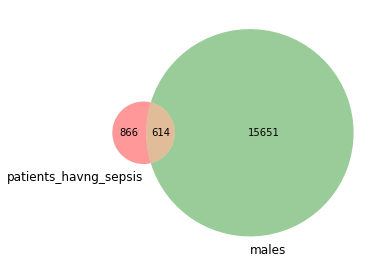

In [101]:
# TO FIND TOTAL MALES HAVING SEPSIS 


drgcodes['SEPSIS'] = (drgcodes['DESCRIPTION'].str.contains('sepsis',case = 0))
drgcodes['SEPSIS'] = drgcodes['SEPSIS'].map({False: 0, True: 1})

drgcodes['sepsis'] = drgcodes['SEPSIS'].apply(lambda x: x if x == 0 or x == 1 else -1)
drgcodes.drop(drgcodes[drgcodes['sepsis'] == -1].index, inplace=True)

chart_icu = pd.merge(chart_icu, patient_admission,how = 'inner',on = ['SUBJECT_ID','HADM_ID'])

# PATIENTS WHO ARE HAVING SEPSIS
temp = drgcodes
temp.drop(temp[~temp['sepsis'].isin([1])].index,inplace=True)

# TOTAL MALES
temp2 = chart_icu
temp2.drop(temp2[~temp2['sex'].isin([0])].index,inplace=True)

# PLOTTING VENN DIAGRAM
plt.figure(figsize=(5,5))
set1 = set(temp['SUBJECT_ID'])
set2 = set(temp2['SUBJECT_ID'])

venn2([set1, set2], ('patients_havng_sepsis', 'males'))
plt.show()


In [102]:
chartevents=pd.read_csv("/Users/sirisadashiva/Desktop/Machine_Learning/mimic3/chartevents_split2.csv")
chartevents.drop(['ROW_ID'], axis=1, inplace=True)

##############################################################################################################

icu_stays=pd.read_csv("/Users/sirisadashiva/Desktop/Machine_Learning/mimic3/ICUSTAYS.csv")
icu_stays.drop(['ROW_ID'], axis=1, inplace=True)

##############################################################################################################

patients = pd.read_csv('/Users/sirisadashiva/Desktop/Machine_Learning/mimic3/PATIENTS.csv')
patients.drop(['ROW_ID'], axis=1, inplace=True)

##############################################################################################################

admissions= pd.read_csv('/Users/sirisadashiva/Desktop/Machine_Learning/mimic3/ADMISSIONS.csv')
admissions.drop(['ROW_ID'], axis=1, inplace=True)

##############################################################################################################

d_items = pd.read_csv('/Users/sirisadashiva/Desktop/Machine_Learning/mimic3/d_items.csv')
d_items.drop(['ROW_ID'], axis=1, inplace=True)

##############################################################################################################

drgcodes = pd.read_csv("/Users/sirisadashiva/Desktop/Machine_Learning/mimic3/DRGCODES.csv")
drgcodes.drop(['ROW_ID'], axis=1, inplace=True)


In [103]:
#############################################PATIENT & ADMISSION##############################################################


admissions['minadmit']=admissions.groupby('SUBJECT_ID')['ADMITTIME'].transform('min')


# I merging patients and admissions

patient_admission =pd.merge(patients, admissions,how = 'inner',on = ['SUBJECT_ID'])

#converting mindadmit time and DOB into datetime format
patient_admission['minadmit'] = pd.to_datetime(patient_admission['minadmit'], infer_datetime_format=True)
patient_admission['DOB'] = pd.to_datetime(patient_admission['DOB'], infer_datetime_format=True)


# calculating total age through minadmit and date of birth
patient_admission['age'] = list(map(lambda x: x.days , (patient_admission['minadmit'] - patient_admission['DOB'])/365.242 ))

#converting ages < 0 (i.e -285) into 300
patient_admission['age'] = patient_admission['age'].apply(lambda x: 300 if x< 0 else x )


#grouping ages 0: neonate 1:children 2:adult
patient_admission['age_group'] = patient_admission['age'].apply(lambda x: 0 if x<=1 else 
                                                         1 if x>1 and x<18 else 
                                                         2 if x>18 and x<=89 else 
                                                         3 ) 


patient_admission.drop(['DISCHTIME','ADMITTIME','HAS_CHARTEVENTS_DATA','DIAGNOSIS','EDOUTTIME','EDREGTIME','RELIGION','LANGUAGE','DISCHARGE_LOCATION','ADMISSION_LOCATION','ADMISSION_TYPE','minadmit','DEATHTIME','DOB','DOD','DOD_HOSP','DOD_SSN'], axis=1, inplace=True)

patient_admission['sex'] = patient_admission['GENDER'].map({'F': 1, 'M': 0})

patient_admission.drop(['GENDER'], axis=1, inplace=True)



encode_category = LabelEncoder()
patient_admission['marital_encode'] = encode_category.fit_transform(patient_admission['MARITAL_STATUS'].astype(str))

patient_admission['ethnicity_encode'] = encode_category.fit_transform(patient_admission['ETHNICITY'].astype(str))


patient_admission['insurance_encode'] = encode_category.fit_transform(patient_admission['INSURANCE'].astype(str))


patient_admission.drop(['ETHNICITY','MARITAL_STATUS'], axis=1, inplace=True)

#################################################ICUSTAY and CHARTEVENTS############################################################



icu_stays.drop(icu_stays[icu_stays['LOS'] >= 110].index, inplace=True)

#round LOS
icu_stays.LOS = icu_stays.LOS.round()

#converting los of patients into 0 and 1 : 0 if <5 1 if >=5
icu_stays['binary_los'] = icu_stays['LOS'].apply(lambda x: 1 if x >=5 else 0)

icu_stays.drop(['OUTTIME','INTIME','FIRST_CAREUNIT','LAST_CAREUNIT','FIRST_WARDID','LAST_WARDID'], axis=1, inplace=True)


#combining d_items and chartevents
chart_icu= pd.merge(chartevents,d_items,how = 'inner',on = ['ITEMID'])

#combining d_chart with icu_stays
chart_icu = pd.merge(chart_icu, icu_stays,how = 'inner',on = ['SUBJECT_ID','HADM_ID','ICUSTAY_ID'])



#dropping unncessary columns
chart_icu.drop(['ERROR','WARNING','ABBREVIATION','RESULTSTATUS','STOPPED','LINKSTO','PARAM_TYPE','CONCEPTID','STORETIME'], axis=1, inplace=True)


#encoding fields

chart_icu['label_encode'] = encode_category.fit_transform(chart_icu['LABEL'].astype(str))


chart_icu['category_encode'] = encode_category.fit_transform(chart_icu['CATEGORY'].astype(str))



#calculating sofa scores
chart_icu['sofa_score']=0
chart_icu['sofa_sbp'] = 0
chart_icu['sofa_rr'] = 0
chart_icu['sofa_gcs'] = 0
chart_icu['heartrate'] = 0
chart_icu['fever'] = 0


#extracting systolic blood pressure
chart_icu['sofa_sbp'][(chart_icu['UNITNAME'] =='mmHg') & (chart_icu['VALUENUM'] <=100)] = 1

#extracting respiratory rate
chart_icu['sofa_rr'][(chart_icu['UNITNAME'] =='insp/min') & (chart_icu['VALUENUM'] >=22)] = 1

#extracting GCS
chart_icu['sofa_gcs'][(chart_icu['LABEL'] =='GcsApacheIIScore') & (chart_icu['VALUENUM'] <15)] = 1

#Adding up all the scores
chart_icu['sofa_score']=chart_icu['sofa_sbp']+chart_icu['sofa_rr']+chart_icu['sofa_gcs']



chart_icu['heartrate'][(chart_icu['VALUENUM'] > 90) & (chart_icu['VALUEOM'] == 'bpm')] = 1

chart_icu['fever'][((chart_icu['VALUENUM'] > 101) & (chart_icu['UNITNAME'] == '?F')) | (chart_icu['VALUENUM'] > 38.3) & (chart_icu['UNITNAME'] == '?C')] = 1


chart_icu.drop(['CHARTTIME','LABEL','CATEGORY','VALUEOM','UNITNAME','DBSOURCE_y'], axis=1, inplace=True)





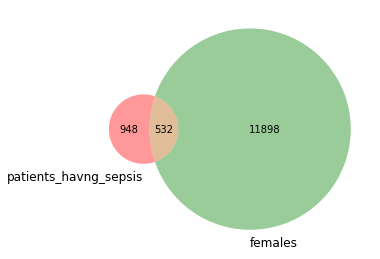

In [104]:
# TO FIND TOTAL FEMALES HAVING SEPSIS 

drgcodes['SEPSIS'] = (drgcodes['DESCRIPTION'].str.contains('sepsis',case = 0))
drgcodes['SEPSIS'] = drgcodes['SEPSIS'].map({False: 0, True: 1})

drgcodes['sepsis'] = drgcodes['SEPSIS'].apply(lambda x: x if x == 0 or x == 1 else -1)
drgcodes.drop(drgcodes[drgcodes['sepsis'] == -1].index, inplace=True)

chart_icu = pd.merge(chart_icu, patient_admission,how = 'inner',on = ['SUBJECT_ID','HADM_ID'])

# PATIENTS WHO ARE HAVING SEPSIS
temp = drgcodes
temp.drop(temp[~temp['sepsis'].isin([1])].index,inplace=True)

# TOTAL FEMALES

temp2 = chart_icu
temp2.drop(temp2[~temp2['sex'].isin([1])].index,inplace=True)


# PLOTTING VENN DIAGRAM

plt.figure(figsize=(5,5))
set1 = set(temp['SUBJECT_ID'])
set2 = set(temp2['SUBJECT_ID'])

venn2([set1, set2], ('patients_havng_sepsis', 'females'))
plt.show()




In [134]:
chartevents=pd.read_csv("/Users/sirisadashiva/Desktop/Machine_Learning/mimic3/chartevents_split2.csv")
chartevents.drop(['ROW_ID'], axis=1, inplace=True)

##############################################################################################################

icu_stays=pd.read_csv("/Users/sirisadashiva/Desktop/Machine_Learning/mimic3/ICUSTAYS.csv")
icu_stays.drop(['ROW_ID'], axis=1, inplace=True)

##############################################################################################################

patients = pd.read_csv('/Users/sirisadashiva/Desktop/Machine_Learning/mimic3/PATIENTS.csv')
patients.drop(['ROW_ID'], axis=1, inplace=True)

##############################################################################################################

admissions= pd.read_csv('/Users/sirisadashiva/Desktop/Machine_Learning/mimic3/ADMISSIONS.csv')
admissions.drop(['ROW_ID'], axis=1, inplace=True)

##############################################################################################################

d_items = pd.read_csv('/Users/sirisadashiva/Desktop/Machine_Learning/mimic3/d_items.csv')
d_items.drop(['ROW_ID'], axis=1, inplace=True)

##############################################################################################################

drgcodes = pd.read_csv("/Users/sirisadashiva/Desktop/Machine_Learning/mimic3/DRGCODES.csv")
drgcodes.drop(['ROW_ID'], axis=1, inplace=True)


In [135]:
#############################################PATIENT & ADMISSION##############################################################


admissions['minadmit']=admissions.groupby('SUBJECT_ID')['ADMITTIME'].transform('min')


# I merging patients and admissions

patient_admission =pd.merge(patients, admissions,how = 'inner',on = ['SUBJECT_ID'])

#converting mindadmit time and DOB into datetime format
patient_admission['minadmit'] = pd.to_datetime(patient_admission['minadmit'], infer_datetime_format=True)
patient_admission['DOB'] = pd.to_datetime(patient_admission['DOB'], infer_datetime_format=True)


# calculating total age through minadmit and date of birth
patient_admission['age'] = list(map(lambda x: x.days , (patient_admission['minadmit'] - patient_admission['DOB'])/365.242 ))

#converting ages < 0 (i.e -285) into 300
patient_admission['age'] = patient_admission['age'].apply(lambda x: 300 if x< 0 else x )


#grouping ages 0: neonate 1:children 2:adult
patient_admission['age_group'] = patient_admission['age'].apply(lambda x: 0 if x<=1 else 
                                                         1 if x>1 and x<18 else 
                                                         2 if x>18 and x<=89 else 
                                                         3 ) 


patient_admission.drop(['DISCHTIME','ADMITTIME','HAS_CHARTEVENTS_DATA','DIAGNOSIS','EDOUTTIME','EDREGTIME','RELIGION','LANGUAGE','DISCHARGE_LOCATION','ADMISSION_LOCATION','ADMISSION_TYPE','minadmit','DEATHTIME','DOB','DOD','DOD_HOSP','DOD_SSN'], axis=1, inplace=True)

patient_admission['sex'] = patient_admission['GENDER'].map({'F': 1, 'M': 0})

#patient_admission.drop(['GENDER'], axis=1, inplace=True)



encode_category = LabelEncoder()
patient_admission['marital_encode'] = encode_category.fit_transform(patient_admission['MARITAL_STATUS'].astype(str))

patient_admission['ethnicity_encode'] = encode_category.fit_transform(patient_admission['ETHNICITY'].astype(str))


patient_admission['insurance_encode'] = encode_category.fit_transform(patient_admission['INSURANCE'].astype(str))


patient_admission.drop(['ETHNICITY','MARITAL_STATUS'], axis=1, inplace=True)


#################################################ICUSTAY and CHARTEVENTS############################################################



icu_stays.drop(icu_stays[icu_stays['LOS'] >= 110].index, inplace=True)

#round LOS
icu_stays.LOS = icu_stays.LOS.round()

#converting los of patients into 0 and 1 : 0 if <5 1 if >=5
icu_stays['binary_los'] = icu_stays['LOS'].apply(lambda x: 1 if x >=5 else 0)

icu_stays.drop(['OUTTIME','INTIME','FIRST_CAREUNIT','LAST_CAREUNIT','FIRST_WARDID','LAST_WARDID'], axis=1, inplace=True)


#combining d_items and chartevents
chart_icu= pd.merge(chartevents,d_items,how = 'inner',on = ['ITEMID'])

#combining d_chart with icu_stays
chart_icu = pd.merge(chart_icu, icu_stays,how = 'inner',on = ['SUBJECT_ID','HADM_ID','ICUSTAY_ID'])



#dropping unncessary columns
chart_icu.drop(['ERROR','WARNING','ABBREVIATION','RESULTSTATUS','STOPPED','LINKSTO','PARAM_TYPE','CONCEPTID','STORETIME'], axis=1, inplace=True)


#encoding fields

chart_icu['label_encode'] = encode_category.fit_transform(chart_icu['LABEL'].astype(str))


chart_icu['category_encode'] = encode_category.fit_transform(chart_icu['CATEGORY'].astype(str))



#calculating sofa scores
chart_icu['sofa_score']=0
chart_icu['sofa_sbp'] = 0
chart_icu['sofa_rr'] = 0
chart_icu['sofa_gcs'] = 0
chart_icu['heartrate'] = 0
chart_icu['fever'] = 0


#extracting systolic blood pressure
chart_icu['sofa_sbp'][(chart_icu['UNITNAME'] =='mmHg') & (chart_icu['VALUENUM'] <=100)] = 1

#extracting respiratory rate
chart_icu['sofa_rr'][(chart_icu['UNITNAME'] =='insp/min') & (chart_icu['VALUENUM'] >=22)] = 1

#extracting GCS
chart_icu['sofa_gcs'][(chart_icu['LABEL'] =='GcsApacheIIScore') & (chart_icu['VALUENUM'] <15)] = 1

#Adding up all the scores
chart_icu['sofa_score']=chart_icu['sofa_sbp']+chart_icu['sofa_rr']+chart_icu['sofa_gcs']



chart_icu['heartrate'][(chart_icu['VALUENUM'] > 90) & (chart_icu['VALUEOM'] == 'bpm')] = 1

chart_icu['fever'][((chart_icu['VALUENUM'] > 101) & (chart_icu['UNITNAME'] == '?F')) | (chart_icu['VALUENUM'] > 38.3) & (chart_icu['UNITNAME'] == '?C')] = 1


chart_icu.drop(['CHARTTIME','LABEL','CATEGORY','VALUEOM','UNITNAME','DBSOURCE_y'], axis=1, inplace=True)




In [136]:
#SEPSIS COHORT 

drgcodes['SEPSIS'] = (drgcodes['DESCRIPTION'].str.contains('sepsis',case = 0))
drgcodes['SEPSIS'] = drgcodes['SEPSIS'].map({False: 0, True: 1})

drgcodes['sepsis'] = drgcodes['SEPSIS'].apply(lambda x: x if x == 0 or x == 1 else -1)
drgcodes.drop(drgcodes[drgcodes['sepsis'] == -1].index, inplace=True)

drgcodes.drop(['SEPSIS','DRG_SEVERITY','DRG_MORTALITY','DRG_TYPE','DESCRIPTION'], axis=1, inplace=True)



sepsis_cohort = pd.merge(positive_culture, drgcodes,how = 'inner',on = ['SUBJECT_ID','HADM_ID'])
sepsis_cohort.drop(['DILUTION_TEXT','DILUTION_COMPARISON','SPEC_TYPE_DESC'], axis=1, inplace=True)



In [137]:

#####################################SEPSIS_COHORT and CHART_ICU#############################################################


chart_icu = pd.merge(chart_icu, patient_admission,how = 'inner',on = ['SUBJECT_ID','HADM_ID'])


sepsis_cohort = pd.merge(sepsis_cohort, chart_icu,how = 'inner',on = ['SUBJECT_ID','HADM_ID'])

#sepsis_cohort.drop(['INTIME','OUTTIME','ICUSTAY_ID'], axis=1, inplace=True)

sepsis_cohort['SUBJECT_ID'].nunique()

#convertnig charttime to datetime
sepsis_cohort['CHARTTIME'] = pd.to_datetime(sepsis_cohort['CHARTTIME'], errors='coerce')


#getting only date in charttime, mincharttime, dropping time
sepsis_cohort['CHARTTIME'] =sepsis_cohort['CHARTTIME'].dt.date


#getting minimum charttime for every row and dropping duplicates
sepsis_cohort['mincharttime'] = sepsis_cohort.groupby('SUBJECT_ID')[['CHARTTIME']].transform('min')
sepsis_cohort.drop(sepsis_cohort[sepsis_cohort['CHARTTIME'] != sepsis_cohort['mincharttime']].index, inplace=True)





sepsis_cohort['interpretation_encode'] = encode_category.fit_transform(sepsis_cohort['INSURANCE'].astype(str))

sepsis_cohort['orgname_encode'] = encode_category.fit_transform(sepsis_cohort['ORG_NAME'].astype(str))

#sepsis_cohort['dbsource'] = encode_category.fit_transform(sepsis_cohort['DBSOURCE'].astype(str))

sepsis_cohort['insurance_encode'] = encode_category.fit_transform(sepsis_cohort['INSURANCE'].astype(str))
sepsis_cohort['dbsource_encode'] = encode_category.fit_transform(sepsis_cohort['DBSOURCE_x'].astype(str))




sepsis_cohort['SPEC_ITEMID'] = sepsis_cohort['SPEC_ITEMID'].apply(lambda x: x if x >=0 else -1)
sepsis_cohort['ORG_ITEMID'] = sepsis_cohort['ORG_ITEMID'].apply(lambda x: x if x >=0 else -1)
sepsis_cohort['AB_ITEMID'] = sepsis_cohort['AB_ITEMID'].apply(lambda x: x if x >=0 else -1)
sepsis_cohort['DILUTION_VALUE'] = sepsis_cohort['DILUTION_VALUE'].apply(lambda x: x if x >=0 else -1)
sepsis_cohort['ITEMID'] = sepsis_cohort['DILUTION_VALUE'].apply(lambda x: x if x >=0 else -1)
sepsis_cohort['CGID'] = sepsis_cohort['DILUTION_VALUE'].apply(lambda x: x if x >=0 else -1)


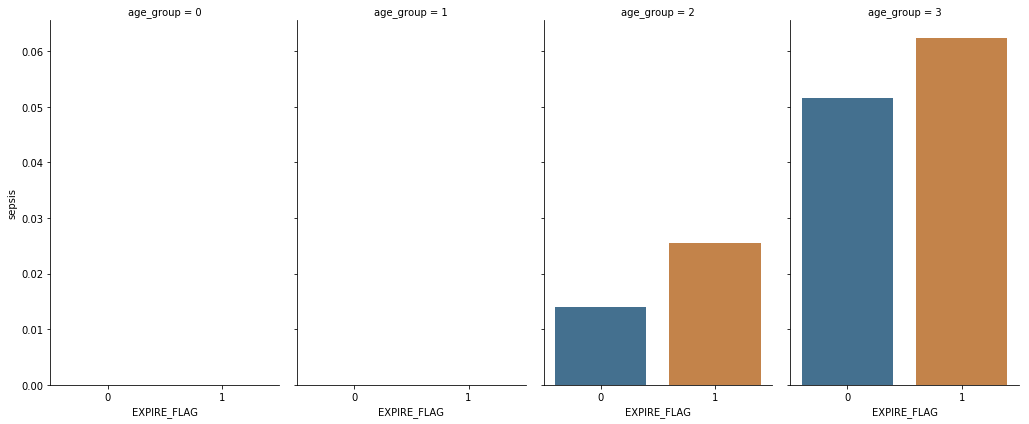

In [73]:
#####################################VISUALIZATION #############################################################

#(0-neonate (<1 year), 1-children(<18 years), 2-Adult (18 to 88 years) 3-Seniors (>89 years)).

#Number of deaths caused by sepsis in every age group.

g = sns.factorplot(x="EXPIRE_FLAG", y="sepsis",col = "age_group",data=sepsis_cohort, saturation=.5,kind="bar", ci=None, size=6,aspect=.6)


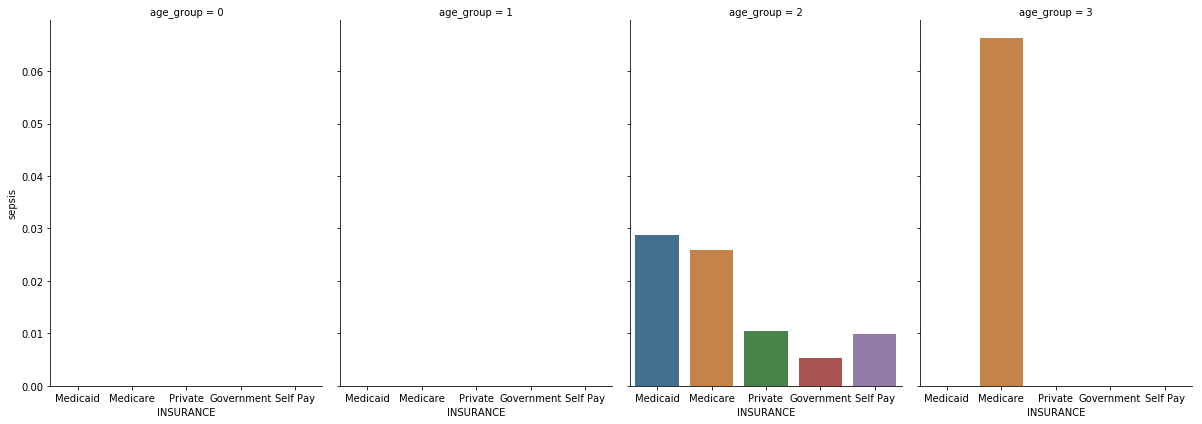

In [80]:
# insurance type used by people in every age group who are diagnosed with sepsis 

g = sns.factorplot(x="INSURANCE", y="sepsis",col = "age_group",data=sepsis_cohort, saturation=.5,kind="bar", ci=None, size=6,aspect=.7)


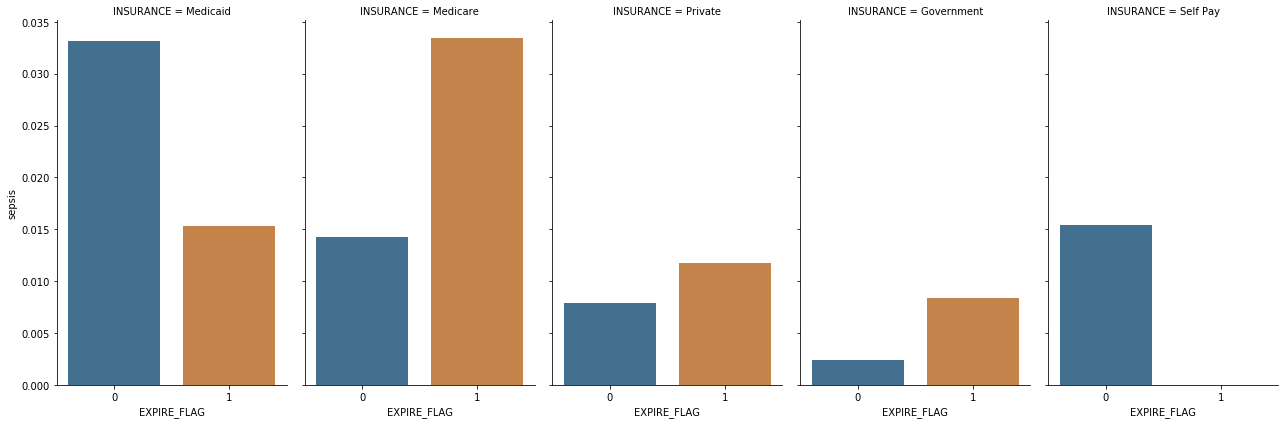

In [109]:
# People who died from sepsis in every insurance type.
g = sns.factorplot(x="EXPIRE_FLAG", y="sepsis",col = "INSURANCE",data=sepsis_cohort, saturation=.5,kind="bar", ci=None, size=6,aspect=.6)


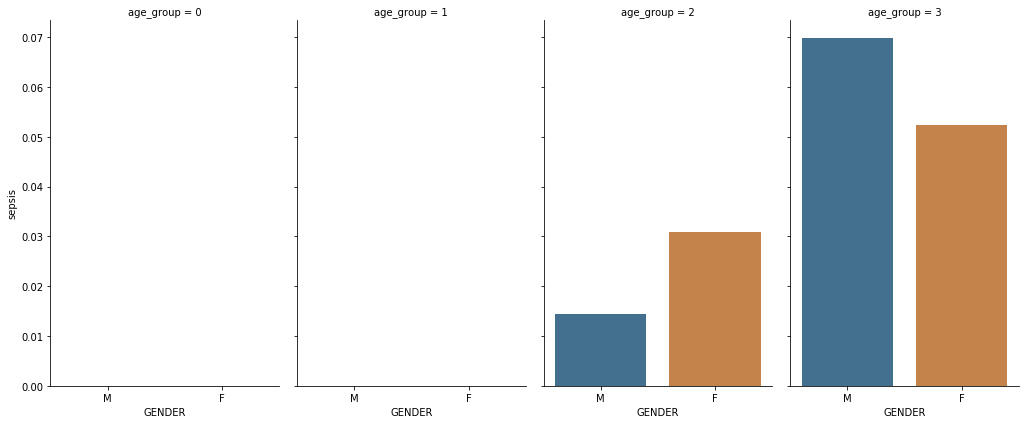

In [86]:
# sepsis population distribution for male and female
g = sns.factorplot(x="GENDER", y="sepsis",col = "age_group",data=sepsis_cohort, saturation=.5,kind="bar", ci=None, size=6,aspect=.6)


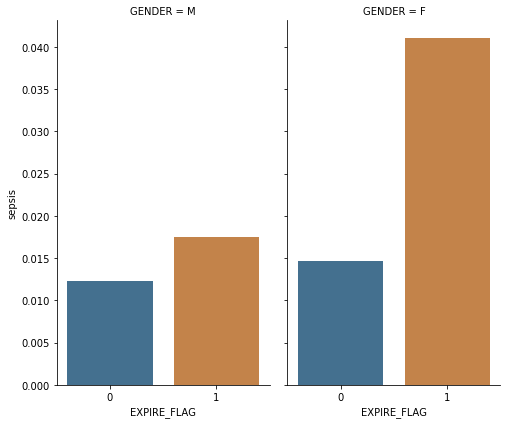

In [88]:
# deaths due to sepsis among male and female population

g = sns.factorplot(x="EXPIRE_FLAG", y="sepsis",col = "GENDER",data=sepsis_cohort, saturation=.5,kind="bar", ci=None, size=6,aspect=.6)


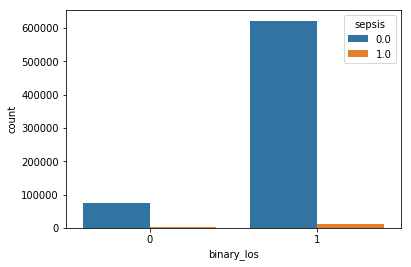

In [89]:
# Length of stay of patients diagonsed with sepsis 
sns.countplot(x='binary_los',hue='sepsis', data=sepsis_cohort)


In [138]:
sepsis_cohort.drop(['CHARTTIME','CHARTDATE','ORG_NAME','INSURANCE','AB_NAME'], axis=1, inplace=True)


In [139]:
########################################MODELING#############################################################

#Test -Train Split

X = sepsis_cohort.drop(['GENDER','ORG_ITEMID','INTERPRETATION','ICUSTAY_ID','VALUE','VALUENUM','DBSOURCE_x','DRG_CODE','age_group','mincharttime','HADM_ID','SUBJECT_ID','binary_los','LOS','sepsis'], axis=1)


y = sepsis_cohort['sepsis']

y1 = sepsis_cohort['binary_los']


sm = SMOTE(random_state=101)

X_res, y_res = sm.fit_sample(X, y)

Counter(y_res)

kf = KFold(n_splits=10,shuffle=True)


X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, random_state=101)



0.975177926989
0.974953631148
0.975005391727
0.974988138201
0.975074405832
0.975031272016
0.975123290823
0.975111788472
0.975134793173
0.975103161709
Accuracy is:
0.975103161709
Confusion Matrix:
[[168341   5319]
 [  3339 170756]]
Classification Report:
             precision    recall  f1-score   support

        0.0       0.98      0.97      0.97    173660
        1.0       0.97      0.98      0.98    174095

avg / total       0.98      0.98      0.98    347755



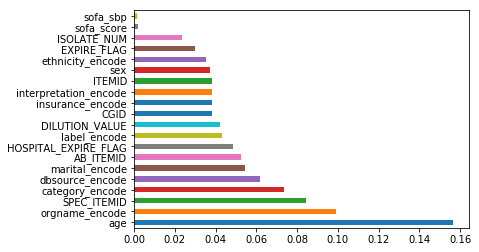

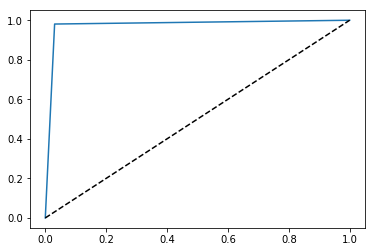

Area under curve (AUC):  0.975096000648


In [112]:
####################################RANDOM FOREST########################################################################


clf = RandomForestClassifier(n_estimators=100)

for k, (train, test) in enumerate(kf.split(X, y)):
    clf.fit(X_train,y_train)
    print(clf.score(X_test, y_test))
  
  
#Performance Check
print("Accuracy is:")
print(clf.score(X_test, y_test))
print("Confusion Matrix:")
print(confusion_matrix(y_test, clf.predict(X_test)))
print("Classification Report:")
print(classification_report(y_test, clf.predict(X_test)))

#Plotting feature importance
feat_importances = pd.Series(clf.feature_importances_, index=X.columns)
feat_importances = feat_importances.nlargest(20)
feat_importances.plot(kind='barh')
plt.show()


#Area under curve
y_score = clf.predict(X_test)
fpr, tpr, _ = roc_curve(y_test, y_score)

plt.plot(fpr,tpr)
plt.plot((0,1), ls='dashed',color='black')

plt.show()
print ('Area under curve (AUC): ', auc(fpr,tpr))



Accuracy is
0.978617129876
Confusion Matrix:
[[169288   4372]
 [  3064 171031]]
Classification Report:
             precision    recall  f1-score   support

        0.0       0.98      0.97      0.98    173660
        1.0       0.98      0.98      0.98    174095

avg / total       0.98      0.98      0.98    347755



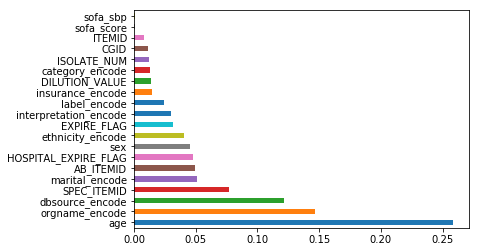

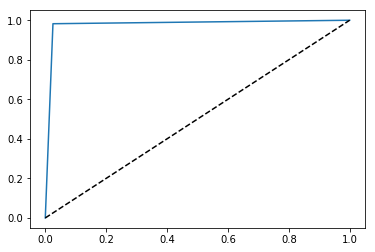

Area under curve (AUC):  0.978612391512


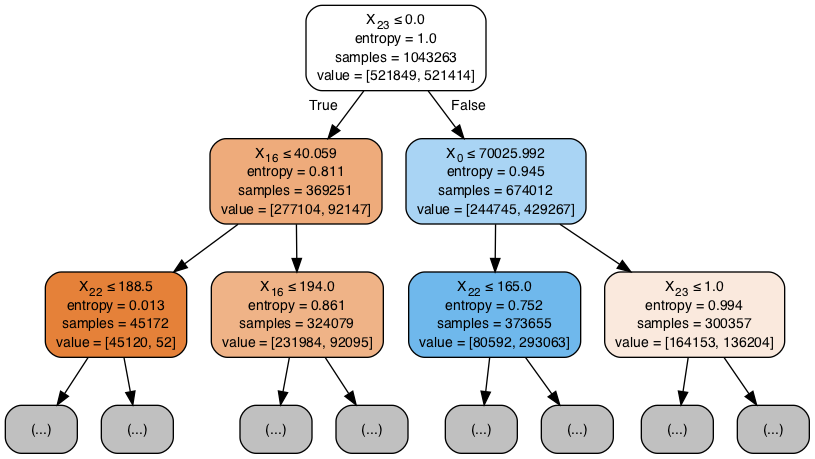

In [140]:
####################################DECISION TREE########################################################################

clf_entropy = DecisionTreeClassifier(criterion = "entropy", random_state = 100,max_depth=35, min_samples_leaf=10)
clf_entropy.fit(X_train, y_train)

y_pred_en = clf_entropy.predict(X_test)


print("Accuracy is")
print(accuracy_score(y_test,y_pred_en))
print("Confusion Matrix:")
print(confusion_matrix(y_test, clf_entropy.predict(X_test)))
print("Classification Report:")
print(classification_report(y_test, clf_entropy.predict(X_test)))

#Plotting feature importance
feat_importances = pd.Series(clf_entropy.feature_importances_, index=X.columns)
feat_importances = feat_importances.nlargest(20)
feat_importances.plot(kind='barh')
plt.show()


#Area under curve
y_score = clf_entropy.predict(X_test)
fpr, tpr, _ = roc_curve(y_test, y_score)

plt.plot(fpr,tpr)
plt.plot((0,1), ls='dashed',color='black')

plt.show()
print ('Area under curve (AUC): ', auc(fpr,tpr))


#Graph Decision tree the top few levels to look at features

dot_data = StringIO()
export_graphviz(clf_entropy, out_file=dot_data,  
                max_depth=2,
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())




Accuracy is
0.920029906112
Confusion Matrix:
[[161922  11738]
 [ 16072 158023]]
Classification Report:
             precision    recall  f1-score   support

        0.0       0.91      0.93      0.92    173660
        1.0       0.93      0.91      0.92    174095

avg / total       0.92      0.92      0.92    347755



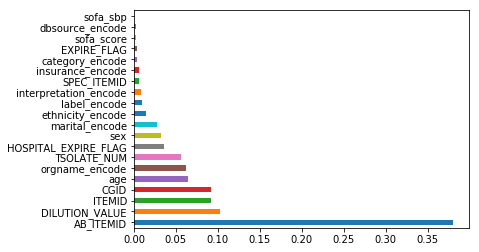

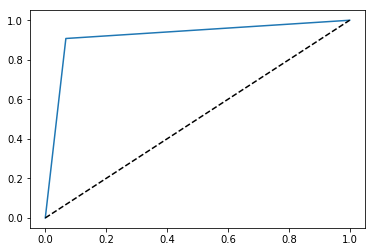

Area under curve (AUC):  0.920045370479


In [115]:
####################################ADA BOOST########################################################################


clf = AdaBoostClassifier(n_estimators=500,learning_rate=1, random_state=0)
model = clf.fit(X_train, y_train)

print("Accuracy is")
print (accuracy_score(y_test, model.predict(X_test)))
print("Confusion Matrix:")
print(confusion_matrix(y_test, clf.predict(X_test)))
print("Classification Report:")
print(classification_report(y_test, clf.predict(X_test)))


#Plotting feature importance
feat_importances = pd.Series(clf.feature_importances_, index=X.columns)
feat_importances = feat_importances.nlargest(20)
feat_importances.plot(kind='barh')
plt.show()

#Area under curve
y_score = clf.predict(X_test)
fpr, tpr, _ = roc_curve(y_test, y_score)

plt.plot(fpr,tpr)
plt.plot((0,1), ls='dashed',color='black')

plt.show()
print ('Area under curve (AUC): ', auc(fpr,tpr))

